# Capstone Project 1 - In-Depth Analysis
## Name: Brock Nosbisch

# Summary:

### I ran the entire dataset using Logistic Regression, k-NN, Random Forest, and SVM and also ran each for 3 different buckets of Monthly Incomes.  The best overall results for Predicting Defaults is using the Logistic Regression using Balanced Weight.  65% of the Defaults were predicted but a large amount of non-defaults were mislabled as defaults (24%).  Similar results were returned when running the Monthly Income buckets using Logistic Regression with Balanced Weight.

### I also performed the same above tests but on a custom scorer that can be modified to show the profit / loss using different algorithms.  The custom scoring has 3 cost factors, Average Loan Amount, Average Interest Rate (revenue taken in), and Average Loan Length.  These factors have been set to $50,000, 4%, and 2 years respectively. 

### Using these factors, if the scorer correctly predicts a non-defaulter then the profit is 4,000 (loan amount x rate x length).  If the scorer incorrectly labels a defaulter as a non-defaulter then the loss is 50,000 (loan amount).  If the scorer incorrectly labels a non-defaulter as a defaulter then the loss is 4,000 (profit we would have taken in).
### The below results show the Profits taken in for each algorithm.  The Logistic Regression (3 Monthly Income Buckets with Balanced Weight Class) had the best Profit predicted with over 110 million followed by Logistic Regression (Balanced Class Weight) and Random Forest Resampling (3 Monthly Income Buckets) all had Profits of 79+ million dollars.  All others resulted in 70 million dollars or less.  Do note that SVM was run initially but had to be removed due to computational power.
### Results for each model tested:
| Algorithm                                                        | Profit         |
|------------------------------------------------------------------|----------------|
| Logistic Regression                                              | 50,930,000.00  |
| Logistic Regression (tuned parameters)                           | 56,720,000.00  |
| Logistic Regression (Balanced Class Weight)                      | 88,898,000.00  |
| k-NN (Best Neighbors, Uniform Weight)                            | 26,746,000.00  |
| k-NN Resampling (Default Counts =   Non-Default Counts)          | 20,728,000.00  |
| Random Forest (Max Features = 10)                                | 59,024,000.00  |
| Random Forest (Balanced Weight Class)                            | 52,662,000.00  |
| Random Forest Resampling (Default Counts   = Non-Default Counts) | 69,020,000.00  |
| Logistic Regression (3 Monthly Income Buckets)                   |113,208,000.00  |
| k-NN (3 Monthly Income Buckets)                                  | 42,288,000.00  |
| Random Forest (3 Monthly Income Buckets)                         | 79,794,000.00  | 

# Load Packages / Data / Notebooks

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy import stats
# from statsmodels.nonparametric.kernel_regression import KernelReg

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

file_name = 'eda_out.csv'
df = pd.read_csv(file_name, header=0, na_values ='-1')
df.set_index('id', inplace=True)
# df.info()


In [67]:
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, high_z = r_z-z*se, r_z+z*se
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

# Bootstrap Replicates
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Test SVM
# Pass X_train, y_train, X_test, y_test, Maximum Iterations you want, C values in a list 
def svm_test(X_train, y_train, X_test, y_test, maxiter=1000, crange=[0.01,0.1,1,10,100]):
    # X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10)
    model = svm.LinearSVC(C=1, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #tune parameter C
    # crange = [0.01,0.1,1,10,100,1000]
    for num in crange:
        model = svm.LinearSVC(C=num, max_iter = maxiter)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print ('C=' + str(num) + ',score={}'.format(accuracy_score(y_test,y_pred)))
        print(confusion_matrix(y_test, y_pred))
        
def print_stats(y_test, y_pred):
    
    profit = 0
    
    avg_loan_amount = 50000 # Average Loan Amount
    avg_interest_rate = .04 # Average interest rate we take in for paid loans
    avg_loan_years = 2      # Average number of years it takes to payoff a loan
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print()
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    total_profit = (tp * avg_loan_amount * avg_interest_rate * avg_loan_years) + (fp * avg_loan_amount * avg_interest_rate * avg_loan_years * -1) + (fn * avg_loan_amount * -1)
    print('Total Profit {}'.format(total_profit))
    print()
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print()
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
    

def print_cv_scores(clf, X_test, y_test, scoring_type, n_CV=5, jobs=-1):
    cv_scores = cross_val_score(clf, X_test, y_test, cv=n_CV, scoring=scoring_type, n_jobs=jobs)
    print('CV Scores:')
    print(cv_scores)
    print()
    cv_score_avg = np.mean(cv_scores)
    print('Total Profit: ' + str(cv_score_avg*n_CV))
    print()



## Custom Scoring Function

In [68]:
  
# 20190625 - New Function to be used as Custom Scorer
def prof_scorer(y_test, y_pred):
    
    cnt00 = 0
    cnt01 = 0
    cnt10 = 0
    cnt11 = 0
    
    profit = 0
    
    avg_loan_amount = 50000 # Average Loan Amount
    avg_interest_rate = .04 # Average interest rate we take in for paid loans
    avg_loan_years = 2      # Average number of years it takes to payoff a loan

    for index in range(len(y_test)):
        y = y_test.iloc[index]
        y_p = y_pred[index]

        if y == 0 and y_p == 0: # TP
            profit += avg_loan_amount * avg_interest_rate * avg_loan_years # amt * rate * years = profit
            cnt00 += 1
        elif y == 0 and y_p == 1: # FP
            profit -= avg_loan_amount * avg_interest_rate * avg_loan_years # amt * rate * years = profit
            cnt01 += 1
        elif y == 1 and y_p == 0: # FN
            profit -= avg_loan_amount # We are assuming that a False Positive will result in losing the entire loan amount.
            cnt10 += 1
        elif y == 1 and y_p == 1: # TN
            profit += 0  # No cost since we identified the Defaulters
            cnt11 += 1
        else:
            raise ValueError("Something went wrong " + str(index))

    return profit

# This is our customer Scorer to use.
profit_scorer = make_scorer(prof_scorer, greater_is_better=True)  # The higher the revenue the better.


In [69]:
# Find monthly income median
# df['monthly_income'][df['monthly_income'].isnull()] = 0
monthly_median = np.median(df['monthly_income'])
df.loc[df.monthly_income == 0, 'monthly_income'] = monthly_median # Set the 0's to median value.
df['monthly_income'] = df['monthly_income'].fillna(0) # Fill all NULL monthly incomes to 0.
df.astype({'monthly_income':'int64'})

#df.loc[df.monthly_income == 0, 'monthly_income'] = monthly_median # Set the 0's to median value.

# Need to do a little clean up on number_of_dependents
df['number_of_dependents'] = df['number_of_dependents'].fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


# Train / Test / Split

In [70]:

X = df.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y = df['serious_delinquent']

# Split the Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50) 


# Split the Training and Test Sets for upsampling.
# I am using the same Random Stage so the data will be the same as above BUT to resample, we need X_train_2 to have the 'serious_delinquent' value so that we can balance the data.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=.4, random_state=50) 

X_train_2['serious_delinquent'] = y_train_2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### Resampling to Upsample

In [71]:
# Resampling to Upsample our Defaults.

from sklearn.utils import resample

# Separating default and non-defaults
df_default = X_train_2[X_train_2['serious_delinquent'] == 1] 
df_no_default = X_train_2[X_train_2['serious_delinquent'] == 0]

print('Number of Defaults: {}'.format(np.ma.count(df_default['serious_delinquent'])))
print('Number of Non-Defaults: {}'.format(np.ma.count(df_no_default['serious_delinquent'])))

resample_count = np.ma.count(df_no_default['serious_delinquent']) # Need to resample the defaults - np.ma.count(df_default['serious_delinquent'])

df_default_samples = resample(df_default, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of New Defaults (resampled): {}'.format(np.ma.count(df_default_samples['serious_delinquent'])))
print()

df_resampled = pd.concat([df_default_samples, df_no_default]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['serious_delinquent'])))

# Resampled dependent/independent.
X_r = df_resampled.drop(columns = ['serious_delinquent']) # ,'age_bucket_name','monthly_income_name']) # Drop columns not needed.
y_r = df_resampled['serious_delinquent']

# 20190627 bn - X_r, y_r are already split.  No need to train/test/split again.
# X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=.4, random_state=50)


Number of Defaults: 5933
Number of Non-Defaults: 83905
Number of New Defaults (resampled): 83905

Count of Records after Resampling: 167810


# Logistic Regression

### The Confusion Matrix is showing the below which looks good:
* Accuracy was 94% (56,177 out of 59,892)
* Precision was 94% (tp / (tp + fp))
* Recall was 99% (tp / (tp + fn))
* F1 Score is 96% (2 * ((p * r) / (p + r)))

### But if I look at how well I did predicting the Defaults, the model predicted a total of 1,003 Defaults and 617 of those were actual Defaults.  The total actual count of Defaults was 3,946.  These results are not satisfactory.
* Predicted 617 defaults out of 3,946 total defaults (16%)
* Out of 1,003 predicted defaults, 617 were actual defaults (62%)
* F1 Score is 25%
### The Average 10-fold Cross Validation score is 93.8%.


In [72]:
n_CV = 10

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[5254000. 4388000. 5236000. 4732000. 5706000. 6130000. 6024000. 5514000.
 5158000. 5400000.]

Total Profit: 53542000.0



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[55608   338]
 [ 3403   543]]


Total Profit 50930000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.62      0.14      0.22      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.78      0.57      0.60     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9375375676217191


### It seems that using optimizing the parameters did not help much since the matrix is about the same as above but the total profit is a little higher.

In [73]:
# GridSearchCV with LogReg
n_CV = 5

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 10) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)
# scoring = {'AUC': 'roc_auc', 'ROC AUC SCORE': 'roc_auc_score', 'Balanced Accuracy': 'balanced_accuracy_score'}

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[10540000. 10558000. 11518000. 11886000. 11306000.]

Total Profit: 55808000.0

Confusion Matrix:
[[55513   433]
 [ 3272   674]]


Total Profit 56720000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.61      0.17      0.27      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.78      0.58      0.62     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9381386495692247


## Logistic Regression (Balanced)
### After passing the class_weight='balanced' parameter, the Confusion Matrix is showing the below which appears to be worse than above.
* Accuracy was 83.8% (50,234 / 59,892)
* Precision was 97%
* Recall was 85%
* F1 Score is 91%

### But since the weighting was balanced (n_samples / (n_classes * np.bincount(y))), the model predicted a total of 10,866 Defaults and 2,577 of those were actual Defaults.  The total actual count of Defaults was 3,946.
* Predicted 2,577 defaults out of 3,946 total defaults (65%)
* Out of 10,866 predicted defaults, 2,577 were actual defaults (24%)
* F1 Score is 35%

### So using the Balanced method gave us a much higher percentage (65%) of finding all the Defaults but 8,284 predicted defaults did not actually default (15% of all non-defaulters).  This may seem like the balanced model was worse but the model is being used to find the people who will default.  Since defaulters cost the company a lot more than the non-defaulters make in revenue then wrongly classifying a non-defaulter as a defaulter is an okay trade-off.


In [74]:
# Logistic Regression (balanced)

logreg_bal = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier

print_cv_scores(logreg_bal, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg_bal.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_bal.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[17858000. 17404000. 18586000. 17144000. 17740000.]

Total Profit: 88732000.0

Confusion Matrix:
[[47604  8342]
 [ 1363  2583]]


Total Profit 88898000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     55946
           1       0.24      0.65      0.35      3946

   micro avg       0.84      0.84      0.84     59892
   macro avg       0.60      0.75      0.63     59892
weighted avg       0.92      0.84      0.87     59892


Accuracy Score: 0.8379583249849729


### The Average 10-fold Cross Validation score is 84%.

In [75]:
# Cross Validation w/ Balance
n_CV = 10

logreg3 = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier

print_cv_scores(logreg3, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 


CV Scores:
[8180000. 9682000. 8164000. 9256000. 9716000. 8980000. 8876000. 8218000.
 8944000. 8776000.]

Total Profit: 88792000.0



## ROC Curve of Balanced Logistic Regression

ROC AUC Score: 0.8251213306133355



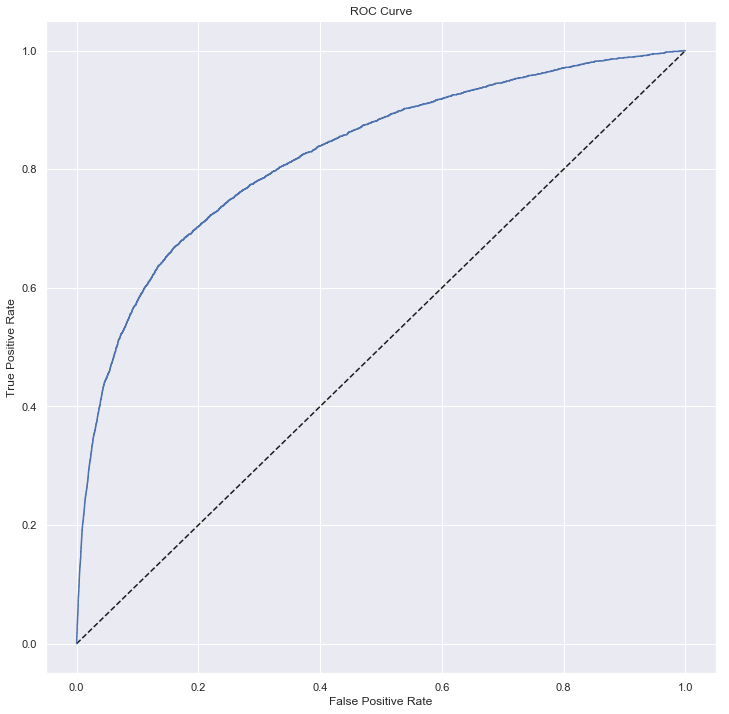

In [76]:
# ROC Curve
y_pred_prob = logreg_bal.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# k-NN

### Finding the Best Params / Score to use results in using 5 k-fold and results in a k-NN Score of 93.4%

In [77]:
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn = KNeighborsClassifier()

print_cv_scores(knn, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn_cv = GridSearchCV(knn, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_cv.fit(X_train, y_train)

print('k-NN Best Params: {}'.format(knn_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_cv.best_score_))

knn_neighbors = knn_cv.best_params_


CV Scores:
[5372000. 5186000. 5456000. 5466000. 5350000.]

Total Profit: 26830000.0

k-NN Best Params: {'n_neighbors': 4}
k-NN Best Score: 7917998.352590218


### Use the k-NN Best n-neighbors.

In [78]:
knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'], weights='uniform')

print_cv_scores(knn, X_test, y_test, profit_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Prediction: {}'.format(y_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))

print_stats(y_test, y_pred)

CV Scores:
[5440000. 5278000. 5434000. 5294000. 5254000.]

Total Profit: 26700000.0

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9333466907099446
Confusion Matrix:
[[55885    61]
 [ 3931    15]]


Total Profit 26746000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     55946
           1       0.20      0.00      0.01      3946

   micro avg       0.93      0.93      0.93     59892
   macro avg       0.57      0.50      0.49     59892
weighted avg       0.89      0.93      0.90     59892


Accuracy Score: 0.9333466907099446


### The Confusion Matrix for k-NN with k=10 has the below results which look really good!
* Accuracy was 93% (55,944 / 59,892)
* Precision was 93%
* Recall was 100%
* F1 Score is 97%

### But the model basically just said that all but 3 people would not default.  This does not help us since we want to identify those defaulters.  Next I will upsample the defaults.


In [79]:
#print_stats(y_test, y_pred)

### Upsampling the Defaults so that the occurence of Defaults vs. non-Defaults is 50/50.

### Resampling with k=10 (best param / score).  With this method we were able to predict 1,649 out of 3,986 defaults but mislabeled 16,004 non-defaults as defaults.

In [80]:

knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'])

knn.fit(X_r, y_r)

##################################################

# Now running on the original dataset to see what our output is.
y_r_pred = knn.predict(X_test)  # Use the actual dataset to test

print('Prediction: {}'.format(y_r_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))
print()

# Running the below doesn't really tell us much because the prediction was run on the balanced dataset.

print_stats(y_test, y_r_pred)


Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.8647732585320244

Confusion Matrix:
[[51139  4807]
 [ 3292   654]]


Total Profit 20728000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     55946
           1       0.12      0.17      0.14      3946

   micro avg       0.86      0.86      0.86     59892
   macro avg       0.53      0.54      0.53     59892
weighted avg       0.89      0.86      0.87     59892


Accuracy Score: 0.8647732585320244


### ROC Curve results in an AUC Score of 59.7%

ROC AUC Score: 0.5600195686851681



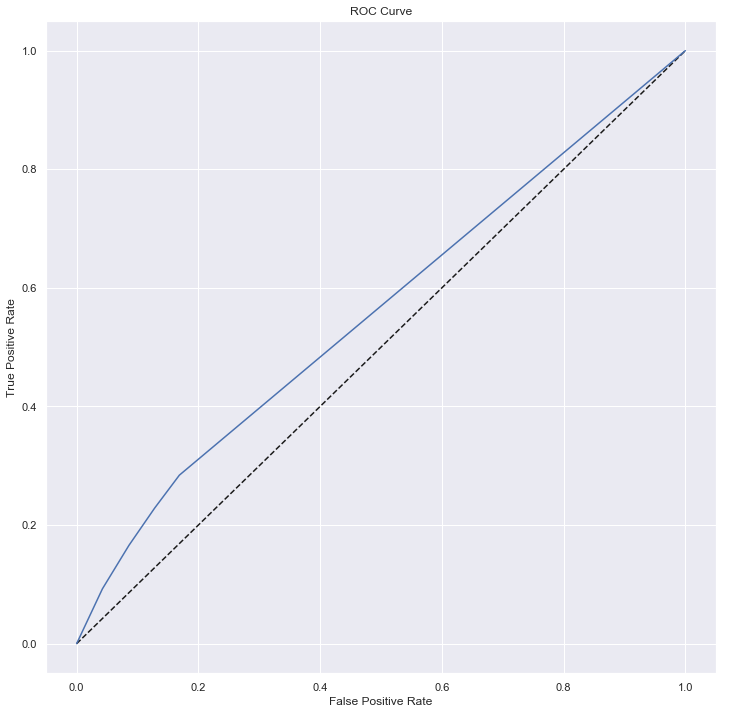

In [81]:
# ROC Curve
y_r_pred_prob = knn.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# Random Forests

### Finding the Best Features to Use results in Age (10.4%), Debt Ratio (14.7%), Monthly Income (11.5%), and Unsecured Lines (17%) being the best features.

In [82]:
# Feature Importance

features = X_train.keys() # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('age', 0.10461114112666738)
('age_bucket', 0.031325183549028385)
('debt_ratio', 0.14771403442082381)
('debt_ratio_bucket', 0.026543368947936224)
('debt_ratio_name', 0.026570424974155512)
('monthly_income', 0.11522619901776895)
('monthly_income_bucket', 0.03172551510494902)
('past_due_30_59', 0.035615758018808626)
('past_due_30_59_flag', 0.014872357259097533)
('past_due_60_89', 0.023376041533423306)
('past_due_60_89_flag', 0.017131485548056796)
('past_due_90_plus', 0.05270010665388279)
('past_due_90_plus_flag', 0.04084179736906985)
('open_credit_lines', 0.08768627626361078)
('unsecured_lines', 0.170428715056685)
('real_estate_loans', 0.03280710143093748)
('number_of_dependents', 0.040824493725098394)


### Using all Features in the actual data set gives not so good results.  Only 733 of the 3,946 defaults were predicted.

In [83]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print(clf.get_params())



clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_depth=100, n_jobs=-1) # 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print(clf.get_params())



clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=10, n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print(clf.get_params())


Confusion Matrix:
[[55346   600]
 [ 3213   733]]


Total Profit 58334000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     55946
           1       0.55      0.19      0.28      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.59      0.62     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9363354037267081
Confusion Matrix:
[[55346   600]
 [ 3213   733]]


Total Profit 58334000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     55946
           1       0.55      0.19      0.28      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.59      0.62     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9363354037267081
Confusion Matrix:
[[55276   670]
 [ 3188   758]]


Total Profit 59024000.0

In [86]:
# Will no longer run due to performance issues.
#n_CV = 5

#param_grid = {'n_estimators': [1000], 'max_depth': [10, 20, 30, 50]}

#clf_cv = GridSearchCV(clf, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

#clf_cv.fit(X_train, y_train)

#print('Random Forest Best Params: {}'.format(clf_cv.best_params_))
#print('Random Forest Best Score: {}'.format(clf_cv.best_score_))


### Using the Balanced class weight did a little worse in that it only predicted 603 out of the 3,946 defaults.

In [87]:
# Using the Actual Dataset with Class_Weight = 'balanced'

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, class_weight = 'balanced', n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)


Confusion Matrix:
[[55462   484]
 [ 3345   601]]


Total Profit 52662000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.55      0.15      0.24      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.75      0.57      0.60     59892
weighted avg       0.92      0.94      0.92     59892


Accuracy Score: 0.9360682561944834


### Instead of using the Balanced class weight parameter, I am going to use my balanced dataset where the number of default records is the same as the number of non-default records.
### This results in what looks to be pretty decent results.  1,567 out of the 3,946 defaults were predicted and 2,248 non-defaulters were predicted to default.

In [88]:
# Using the Balanced Dataset

clf = RandomForestClassifier(n_estimators=1000, random_state=50, n_jobs=-1) # max_depth=100,
clf.fit(X_r, y_r)

y_r_pred = clf.predict(X_test) # Use the actual dataset to test

print_stats(y_test, y_r_pred)


Confusion Matrix:
[[54763  1183]
 [ 2906  1040]]


Total Profit 69020000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     55946
           1       0.47      0.26      0.34      3946

   micro avg       0.93      0.93      0.93     59892
   macro avg       0.71      0.62      0.65     59892
weighted avg       0.92      0.93      0.92     59892


Accuracy Score: 0.9317271087958325


### The ROC AUC Score is 84.4.

ROC AUC Score: 0.8400716517986201



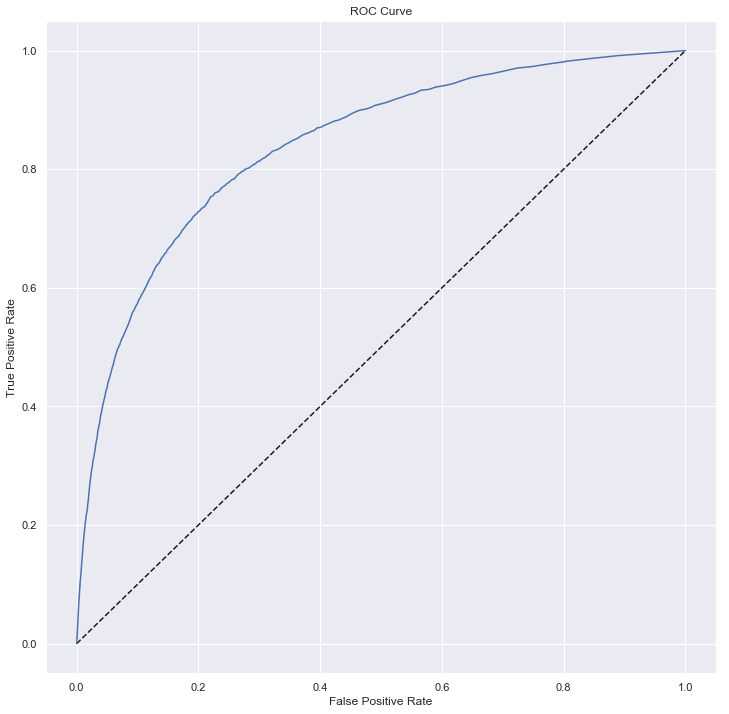

In [89]:
# ROC Curve
y_r_pred_prob = clf.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# SVM

## The SVM results were all sub-par since not many of the defaults were predicted.

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler


In [ ]:

# svm_test(X_train, y_train, X_test, y_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])

In [ ]:
linSVC = svm.LinearSVC(random_state=50,  max_iter = 1000, C=4.0) # tol=1e-5,
linSVC.fit(X_train, y_train)

y_r_pred = linSVC.predict(X_test)

print_stats(y_test, y_r_pred)

# Splitting Up Data Based on Monthly Income

### Splitting up the dataset by Monthly Income into 3 buckets.  
* <= median monthly income
* \> median monthly income
* NaN monthly income (bucket for all records with no monthly income)


### Train / Test / Split
### There will now be 3 DataFrames, Low Income, High Income, NULL Income

In [90]:

# Lower than Monthly Income median
df_low = df[df['monthly_income'] <= df['monthly_income'].median()].copy()

X_low = df_low.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y_low = df_low['serious_delinquent']

# Split the Training and Test Sets
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=.4, random_state=50) 


# NULL Monthly Income median (I set all NULL Monthly Incomes to 0.)
df_med = df[df['monthly_income'] == 0].copy()

X_med = df_med.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y_med = df_med['serious_delinquent']

# Split the Training and Test Sets
X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(X_med, y_med, test_size=.4, random_state=50) 


# Higher (or equal to) than Monthly Income median
df_high = df[df['monthly_income'] > df['monthly_income'].median()].copy()

X_high = df_high.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name']) # ,'monthly_income']) # Drop columns not needed.
y_high = df_high['serious_delinquent']

# Split the Training and Test Sets
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=.4, random_state=50) 


## Logistic Regression

### Splitting up the Monthly Income into the 3 buckets produced okay results for each bucket.  The predictions were about the same as using balanced Logistic Regression with the entire training dataset.
#### Monthly Income <= median
    * Predicted 1,487 out of 2,231 defaults. (67%)
    * Mislabeled 3,773 non-defaults as defaults. (14%)
#### Monthly Income > median
    * Predicted 1,098 out of 1,680 defaults. (65%)
    * Mislabeled 4,563 non-defaults as defaults. (16%)
#### Monthly Income is NULL
    * Predicted 468 out of 692 defaults. (68%)
    * Mislabeled 1,718 non-defaults as defaults. (15%)

In [91]:
# LOW Monthly Income
logreg_low = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.0, n_jobs=-1) # Create the classifier
logreg_low.fit(X_low_train, y_low_train) # Fit the classifier to the training data

y_pred_low = logreg_low.predict(X_low_test) # Predict the labels of the test set

print_stats(y_low_test, y_pred_low)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Confusion Matrix:
[[23950  3773]
 [  744  1487]]


Total Profit 43508000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     27723
           1       0.28      0.67      0.40      2231

   micro avg       0.85      0.85      0.85     29954
   macro avg       0.63      0.77      0.66     29954
weighted avg       0.92      0.85      0.88     29954


Accuracy Score: 0.8492021099018495


In [65]:
# HIGH Monthly Income
logreg_high = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.0, n_jobs=-1) # Create the classifier
logreg_high.fit(X_high_train, y_high_train) # Fit the classifier to the training data

y_pred_high = logreg_high.predict(X_high_test) # Predict the labels of the test set

print_stats(y_high_test, y_pred_high)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Confusion Matrix:
[[23696  4563]
 [  582  1098]]


Total Profit 47432000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     28259
           1       0.19      0.65      0.30      1680

   micro avg       0.83      0.83      0.83     29939
   macro avg       0.58      0.75      0.60     29939
weighted avg       0.93      0.83      0.87     29939


Accuracy Score: 0.8281505728314239


In [64]:
# NULL Monthly Income
logreg_med = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.0, n_jobs=-1) # Create the classifier
logreg_med.fit(X_med_train, y_med_train) # Fit the classifier to the training data

y_pred_med = logreg_med.predict(X_med_test) # Predict the labels of the test set

print_stats(y_med_test, y_pred_med)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Confusion Matrix:
[[10085  1718]
 [  224   468]]


Total Profit 22268000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     11803
           1       0.21      0.68      0.33       692

   micro avg       0.84      0.84      0.84     12495
   macro avg       0.60      0.77      0.62     12495
weighted avg       0.94      0.84      0.88     12495


Accuracy Score: 0.844577831132453


## k-NN

### Splitting up the Monthly Income into the 3 buckets produced high accuracy but this is because there were very little defaults predicted.
        

In [92]:
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn_low = KNeighborsClassifier()

knn_low_cv = GridSearchCV(knn_low, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_low_cv.fit(X_low_train, y_low_train)

y_pred_low = knn_low_cv.predict(X_low_test)

print('k-NN Best Params: {}'.format(knn_low_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_low_cv.best_score_))

print_stats(y_low_test, y_pred_low)

knn_neighbors_low = knn_low_cv.best_params_


k-NN Best Params: {'n_neighbors': 3}
k-NN Best Score: 280800.0
Confusion Matrix:
[[27398   325]
 [ 2156    75]]


Total Profit 492000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     27723
           1       0.19      0.03      0.06      2231

   micro avg       0.92      0.92      0.92     29954
   macro avg       0.56      0.51      0.51     29954
weighted avg       0.87      0.92      0.89     29954


Accuracy Score: 0.9171729985978501


In [93]:
knn_low = KNeighborsClassifier(n_neighbors=knn_neighbors_low['n_neighbors'], weights='distance', n_jobs=-1) #

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

knn_low.fit(X_low_train, y_low_train)

y_pred_low = knn_low.predict(X_low_test)

print('Prediction: {}'.format(y_pred_low))
print('k-NN Score: {}'.format(knn_low.score(X_low_test, y_low_test)))

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9152700807905455


In [94]:
print_stats(y_low_test, y_pred_low)

Confusion Matrix:
[[27335   388]
 [ 2150    81]]


Total Profit 288000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     27723
           1       0.17      0.04      0.06      2231

   micro avg       0.92      0.92      0.92     29954
   macro avg       0.55      0.51      0.51     29954
weighted avg       0.87      0.92      0.89     29954


Accuracy Score: 0.9152700807905455


In [95]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn_med = KNeighborsClassifier()

knn_med_cv = GridSearchCV(knn_med, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_med_cv.fit(X_med_train, y_med_train)

y_pred_med = knn_med_cv.predict(X_med_test)

print_stats(y_med_test, y_pred_med)

print('k-NN Best Params: {}'.format(knn_med_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_med_cv.best_score_))
print()

knn_neighbors_med = knn_med_cv.best_params_


knn_med = KNeighborsClassifier(n_neighbors=knn_neighbors_med['n_neighbors'], weights='uniform')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

knn_med.fit(X_med_train, y_med_train)

y_pred_med = knn_med.predict(X_med_test)

print('Prediction: {}'.format(y_pred_med))
print('k-NN Score: {}'.format(knn_med.score(X_med_test, y_med_test)))
print()

print_stats(y_med_test, y_pred_med)

Confusion Matrix:
[[11756    47]
 [  681    11]]


Total Profit 12786000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11803
           1       0.19      0.02      0.03       692

   micro avg       0.94      0.94      0.94     12495
   macro avg       0.57      0.51      0.50     12495
weighted avg       0.90      0.94      0.92     12495


Accuracy Score: 0.9417366946778711
k-NN Best Params: {'n_neighbors': 2}
k-NN Best Score: 4522404.332515206

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9417366946778711

Confusion Matrix:
[[11756    47]
 [  681    11]]


Total Profit 12786000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11803
           1       0.19      0.02      0.03       692

   micro avg       0.94      0.94      0.94     12495
   macro avg       0.57      0.51      0.50     12495
weighted avg       0.90      0

In [96]:


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn_high = KNeighborsClassifier()

knn_high_cv = GridSearchCV(knn_high, param_grid, cv=n_CV, scoring=profit_scorer, n_jobs=-1) # 5 fold

knn_high_cv.fit(X_high_train, y_high_train)

y_pred_high = knn_high_cv.predict(X_high_test)

print_stats(y_high_test, y_pred_high)

print('k-NN Best Params: {}'.format(knn_high_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_high_cv.best_score_))
print()

knn_neighbors_high = knn_high_cv.best_params_


knn_high = KNeighborsClassifier(n_neighbors=knn_neighbors_high['n_neighbors'], weights='uniform')

knn_high.fit(X_high_train, y_high_train)

y_pred_high = knn_high.predict(X_high_test)

print('Prediction: {}'.format(y_pred_high))
print('k-NN Score: {}'.format(knn_high.score(X_high_test, y_high_test)))
print()

print_stats(y_high_test, y_pred_high)

Confusion Matrix:
[[28250     9]
 [ 1675     5]]


Total Profit 29214000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28259
           1       0.36      0.00      0.01      1680

   micro avg       0.94      0.94      0.94     29939
   macro avg       0.65      0.50      0.49     29939
weighted avg       0.91      0.94      0.92     29939


Accuracy Score: 0.943752296335883
k-NN Best Params: {'n_neighbors': 4}
k-NN Best Score: 7534000.668047298

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.943752296335883

Confusion Matrix:
[[28250     9]
 [ 1675     5]]


Total Profit 29214000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28259
           1       0.36      0.00      0.01      1680

   micro avg       0.94      0.94      0.94     29939
   macro avg       0.65      0.50      0.49     29939
weighted avg       0.91      0.9

## Random Forests

### Splitting up the Monthly Income into the 3 buckets produced okay results for each bucket.
#### Monthly Income <= median
    * Predicted 329 out of 1,533 defaults. (21%)
    * Mislabeled 286 non-defaults as defaults. (2%)
#### Monthly Income > median
    * Predicted 277 out of 1,680 defaults. (16%)
    * Mislabeled 241 non-defaults as defaults. (1%)
#### Monthly Income is NULL
    * Predicted 157 out of 634 defaults. (25%)
    * Mislabeled 147 non-defaults as defaults. (1%)

In [97]:
# Using the actual data

clf_low = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf_low.fit(X_low_train, y_low_train)

y_pred_low = clf_low.predict(X_low_test)

print_stats(y_low_test, y_pred_low)
# print()
# print('Feature Scores: {}'.format(clf.feature_importances_))


Confusion Matrix:
[[27324   399]
 [ 1767   464]]


Total Profit 19350000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     27723
           1       0.54      0.21      0.30      2231

   micro avg       0.93      0.93      0.93     29954
   macro avg       0.74      0.60      0.63     29954
weighted avg       0.91      0.93      0.91     29954


Accuracy Score: 0.9276891233224277


In [98]:
# Using the actual data

clf_med = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf_med.fit(X_med_train, y_med_train)

y_pred_med = clf_med.predict(X_med_test)

print_stats(y_med_test, y_pred_med)
# print()
# print('Feature Scores: {}'.format(clf.feature_importances_))


Confusion Matrix:
[[11631   172]
 [  527   165]]


Total Profit 19486000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     11803
           1       0.49      0.24      0.32       692

   micro avg       0.94      0.94      0.94     12495
   macro avg       0.72      0.61      0.65     12495
weighted avg       0.93      0.94      0.93     12495


Accuracy Score: 0.9440576230492197


In [99]:
# Using the actual data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)
clf_high = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # max_depth=100,
clf_high.fit(X_high_train, y_high_train)

y_pred_high = clf_high.predict(X_high_test)

print_stats(y_high_test, y_pred_high)
# print()
# print('Feature Scores: {}'.format(clf.feature_importances_))




Confusion Matrix:
[[28018   241]
 [ 1403   277]]


Total Profit 40958000.0


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28259
           1       0.53      0.16      0.25      1680

   micro avg       0.95      0.95      0.95     29939
   macro avg       0.74      0.58      0.61     29939
weighted avg       0.93      0.95      0.93     29939


Accuracy Score: 0.9450883463041517


## Annex

In [ ]:
scaler = StandardScaler() # Standarize features
X_std = scaler.fit_transform(X_train)

svc = svm.SVC(class_weight='balanced', C=5.0, random_state=50, probability=True) # kernel='linear', 


In [ ]:
# Train classifier
model = svc.predict(X_std, y_train)


In [ ]:
print(svc.predict_proba(X_test))

In [ ]:
print(svc.predict_log_proba(X_test))

In [ ]:
print_stats(y_test, y_r_pred)

In [ ]:
# GridSearchCV with LogReg 

logreg_low = LogisticRegression(solver='liblinear', class_weight='balanced') # Create the classifier

penalty = ['l1', 'l2'] # regularization penablty space
C = (0.1, 0.5, 1.0, 2.0, 4.0, 10.0) #  np.logspace(0, 4, 10) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)

logreg_low_cv = GridSearchCV(logreg_low, param_grid, scoring='roc_auc', cv=5, n_jobs=-1) # 5 fold
logreg_low_cv.fit(X_low_train, y_low_train) # Fit the classifier to the training data

y_pred_low = logreg_low_cv.predict(X_low_test) # Predict the labels of the test set

print_stats(y_low_test, y_pred_low)

# with Scoring
logreg_low_cv = GridSearchCV(logreg_low, param_grid, scoring=profit_scorer, cv=5, n_jobs=-1) # 5 fold
logreg_low_cv.fit(X_low_train, y_low_train) # Fit the classifier to the training data

y_pred_low = logreg_low_cv.predict(X_low_test) # Predict the labels of the test set

print_stats(y_low_test, y_pred_low)


## SVM

In [ ]:
svm_test(X_low_train, y_low_train, X_low_test, y_low_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])
svm_test(X_med_train, y_med_train, X_med_test, y_med_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])
svm_test(X_high_train, y_high_train, X_high_test, y_high_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])


## Using the entire dataset:

### Logistic Regression
* Correctly predicted 617 defaults out of 3,946 total defaults (16%)
* Correctly predicted 617 defaults out of 1,003 predicted defaults (62%)
* Incorrectly predicted 386 defaults out of 55,946 non-defaults (1%)

### Logistic Regression using GridSearchCV
* Correctly predicted 673 defaults out of 3,946 total defaults (17%)
* Correctly predicted 673 defaults out of 1,109 predicted defaults (61%)
* Incorrectly predicted 436 defaults out of 55,946 non-defaults (1%)

### Logistic Regression using Balanced Weight
* Correctly predicted 2,577 defaults out of 3,946 total defaults (65%)
* Correctly predicted 2,577 defaults out of 10,866 predicted defaults (24%)
* Incorrectly predicted 8,289 defaults out of 55,946 non-defaults (15%)

### k-NN with k=10
* Correctly predicted 1 defaults out of 3,946 total defaults (<1%)
* Correctly predicted 1 defaults out of 3 predicted defaults (33%)
* Incorrectly predicted 2 defaults out of 55,946 non-defaults (<1%)

### k-NN with Resampling
* Correctly predicted 1,649 defaults out of 3,946 total defaults (42%)
* Correctly predicted 1,649 defaults out of 17,653 predicted defaults (9%)
* Incorrectly predicted 16,004 defaults out of 55,946 non-defaults (29%)

### Random Forest
* Correctly predicted 733 defaults out of 3,946 total defaults (19%)
* Correctly predicted 733 defaults out of 1,335 predicted defaults (55%)
* Incorrectly predicted 602 defaults out of 55,946 non-defaults (1%)

### Random Forest using Balanced Weight
* Correctly predicted 603 defaults out of 3,946 total defaults (15%)
* Correctly predicted 603 defaults out of 1,085 predicted defaults (56%)
* Incorrectly predicted 482 defaults out of 55,946 non-defaults (1%)

### Random Forest using Balanced Dataset
* Correctly predicted 1,567 defaults out of 3,946 total defaults (40%)
* Correctly predicted 1,567 defaults out of 3,815 predicted defaults (41%)
* Incorrectly predicted 2,248 defaults out of 55,946 non-defaults (4%)

### SVM results were sub-par.


## Splitting up the dataset based on monthly income.
* < median monthly income
* = median monthly income (I set all NULL and 0 monthly incomes to the median value)
* \> median monthly income

### Logistic Regression (Monthly Income < median)
* Correctly predicted 1,018 defaults out of 1,533 total defaults (66%)
* Correctly predicted 1,018 defaults out of 3,595 predicted defaults (28%)
* Incorrectly predicted 2,577 defaults out of 15,911 non-defaults (16%)

### Logistic Regression (Monthly Income = median)
* Correctly predicted 454 defaults out of 634 total defaults (66%)
* Correctly predicted 454 defaults out of 2,192 predicted defaults (28%)
* Incorrectly predicted 1,738 defaults out of 11,876 non-defaults (15%)

### Logistic Regression (Monthly Income > median)
* Correctly predicted 1,098 defaults out of 1,680 total defaults (65%)
* Correctly predicted 1,098 defaults out of 5,661 predicted defaults (19%)
* Incorrectly predicted 4,563 defaults out of 28,259 non-defaults (16%)

### k-NN results with different buckets were sub-par.

### Random Forest (Monthly Income < median)
* Correctly predicted 329 defaults out of 1,533 total defaults (21%)
* Correctly predicted 329 defaults out of 615 predicted defaults (53%)
* Incorrectly predicted 286 defaults out of 15,911 non-defaults (2%)

### Random Forest (Monthly Income = median)
* Correctly predicted 157 defaults out of 634 total defaults (25%)
* Correctly predicted 157 defaults out of 304 predicted defaults (52%)
* Incorrectly predicted 147 defaults out of 11,876 non-defaults (1%)

### Random Forest (Monthly Income > median)
* Correctly predicted 277 defaults out of 1,680 total defaults (16%)
* Correctly predicted 277 defaults out of 518 predicted defaults (53%)
* Incorrectly predicted 241 defaults out of 28,259 non-defaults (1%)

### SVM results were sub-par.
